In [3]:
import torch
from tqdm import tqdm
import scipy.io as scio
import deepinv as dinv
from deepinv.physics import Denoising, GaussianNoise
from AnomalyDetectionDataset.algo2 import *
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
from deepinv.optim.data_fidelity import L2
import os
from torchmetrics.classification import BinaryAUROC, BinaryF1Score

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Selected GPU 0 with 7957 MB free memory 
Selected GPU 0 with 7957 MB free memory 


In [4]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.cuda.set_per_process_memory_fraction(0.98, 0)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
print(dinv.__version__)

0.2.1


In [5]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"cuDNN enabled: {torch.backends.cudnn.enabled}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.0.1+cu118
CUDA version: 11.8
cuDNN enabled: True
Device name: NVIDIA GeForce RTX 4060 Laptop GPU


In [6]:
def compute_auc_with_params(params_algo, D_noise,e_init, amo_gt, device):
    torch.manual_seed(0)
    tl.set_backend('pytorch')
    # 模拟根据参数生成图像
    with torch.no_grad():    
        
        data_fidelity = L2()

        cur_priorS = L2pPrior(l2_axis = 1, l2p_p = 0.1)
        cur_priorE = StiefelPrior(rank=rank)
        cur_priorZ = GSPnP(denoiser=dinv.models.GSDRUNet(in_channels=1, out_channels=1,pretrained='AnomalyDetectionDataset/GSDRUNet_grayscale_torch.ckpt',alpha=params_algo["lambda"]).to(device)) #pretrained="download" in_channels=12, out_channels=12,
        iteration = PBCDIteration(F_fn=None, has_cost=True)
        X=initialisation2(D_noise,e_init)
        max_iter = 10
        for it in range(max_iter):
            X = iteration(X, data_fidelity, cur_priorS , cur_priorE ,cur_priorZ, params_algo, O=D_noise) # 替换为实际的模型函数
        # 将图像和 ground truth 展平
        S_final=X['est'][0]
        S_map=torch.zeros(S_final.shape[2],S_final.shape[3]).to(device)
        for band in range(S_final.shape[1]):
            S_map=S_final[0,band,:,:]*S_final[0,band,:,:]
        ourdensity=S_map.cpu().detach().numpy()
        amo_gt=amo_gt.cpu().detach().numpy()
        ROC, AUC=ROC_AUC(ourdensity, amo_gt)
    # 计算 AUC
    return ROC,AUC, ourdensity


dealing abu-urban-4
torch.Size([205, 8]) torch.Size([205, 100, 100])


/home/yushijie0404/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


 i=  0   j=  0
saving AnomalyDetectionDataset/20250409/abu-urban-4_result_nl003_auto05496.mat


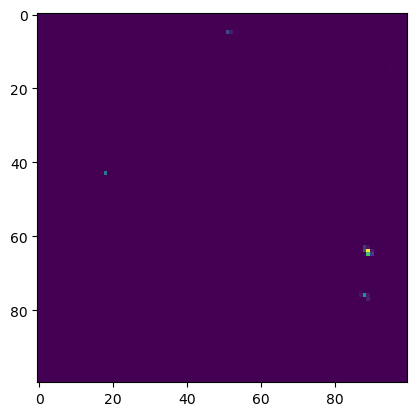

In [7]:
import matplotlib.pyplot as plt
with torch.no_grad():# name = f'abu-urban-{i}''abu-airport-1','abu-airport-2','abu-airport-3''abu-airport-3','abu-airport-4','abu-beach-4''abu-urban-3',,,'abu-urban-2','abu-urban-4'
    for name in ['abu-urban-4']:
        print(f'dealing {name}')
        noise_level_img=0.03
        variables_to_load = ['E_all','D_noise', 'amo_gt']

    # 使用loadmat函数加载指定变量
        data0 = scio.loadmat(f'AnomalyDetectionDataset/20241120/{name}_nl{int((noise_level_img) * 100):03d}.mat',variable_names=variables_to_load)
        
        D_noise=torch.tensor(data0['D_noise'].astype('float32'), dtype=torch.float32).to(device)
        D_noise=D_noise/D_noise.max()
        amo_gt=torch.tensor(data0['amo_gt'], dtype=torch.float32).to(device)
        rank=8
    #    e_init=torch.tensor(data0['E_all'][:,:rank].astype('float32'), dtype=torch.float32).to(device)
        e_init = torch.randn(D_noise.shape[0], rank, dtype=torch.float32).to(device)
        U, SIG, V =torch.linalg.svd(e_init , full_matrices=False)
        SIGone = torch.diag(torch.ones(rank,dtype=torch.float32).to(device)) #!!要和整体输入一致
        e_init = U @ SIGone @ V
        print(e_init.shape,D_noise.shape)
        torch.cuda.empty_cache()
        AUC_all=torch.zeros(1,1).to(device)
        for j in range(AUC_all.shape[1]):
            for i in range(AUC_all.shape[0]):
                params_algo = {
                    "noiselevelparams": 1,
                    "g_param": (0) * torch.ones(rank).to(device),  # 示例 rank = 10
                    #"alpha": 0.5,
                    "delta": 5000000000000+0.1*(j),
                    "tau": 0.000000015+0.1*i,
                    "alpha_S": 0.1,
                    "alpha_E": 0.1,
                    "alpha_Z": 0.09,
                    
                }
                params_algo["tilde_alpha_Z"]  = params_algo["delta"] / (params_algo["delta"]+params_algo["alpha_Z"])
                params_algo["lambda"]  = 1 / params_algo["tilde_alpha_Z"]
                ROC, AUC, ourdensity=compute_auc_with_params(params_algo, D_noise,e_init, amo_gt, device) #, population_size=20, generations=50, mutation_rate=0.1
                AUC_all[i,j]=AUC
                print(" i= ", i ,"  j= ",j )  
        
                saving_ttl=f'AnomalyDetectionDataset/20250409/{name}_result_nl{int((noise_level_img) * 100):03d}_auto{int((AUC) * 10000):05d}.mat'
                print(f'saving {saving_ttl}')
                plt.imshow(ourdensity)
                plt.show()
                scio.savemat(saving_ttl,
                            {'params_algo':params_algo,
                            'ourdensity':ourdensity,
                            'auc':AUC,
                            'AUC_all':AUC_all,})
                torch.cuda.empty_cache()

In [ ]:
print(AUC_all)

In [ ]:

scio.savemat('delta_gamma20250612.mat',{'delta_gamma':AUC_all.to('cpu').numpy(force=True)})

In [ ]:
# 20250409
param_ranges = {
    "stepsize": (0.5, 2),
    "noiselevelparams": (0.2, 1.99),
    "lambda": (0.01, 0.99),
    "alpha": (0.01, 0.99),
    "delta": (0.5, 5),
    "gamma": (0.01, 1.5),
    "t_S": (0, 0.3),
    "t_E": (0.01, 0.01),
    "t_Z": (0, 0.3),
}

# 执行遗传算法
with torch.no_grad():# name = f'abu-urban-{i}''abu-airport-1','abu-airport-2','abu-airport-3','abu-airport-4','abu-beach-4''abu-urban-3',
    for name in ['abu-airport-3']:
        print(f'dealing {name}')
        noise_level_img=0.00
        variables_to_load = ['E_all','D_noise', 'amo_gt']

    # 使用loadmat函数加载指定变量
        data0 = scio.loadmat(f'AnomalyDetectionDataset/20241120/{name}_nl{int((noise_level_img) * 100):03d}.mat',variable_names=variables_to_load)
        D_noise=torch.tensor(data0['D_noise'].astype('float32'), dtype=torch.float32).to(device)
        D_noise=D_noise/D_noise.max()
        amo_gt=torch.tensor(data0['amo_gt'], dtype=torch.float32).to(device)
        rank=8
    #    e_init=torch.tensor(data0['E_all'][:,:rank].astype('float32'), dtype=torch.float32).to(device)
        e_init = torch.randn(D_noise.shape[0], rank, dtype=torch.float32).to(device)
        U, SIG, V =torch.linalg.svd(e_init , full_matrices=False)
        SIGone = torch.diag(torch.ones(rank,dtype=torch.float32).to(device)) #!!要和整体输入一致
        e_init = U @ SIGone @ V
        print(e_init.shape,D_noise.shape)
        torch.cuda.empty_cache()

        AUC, ourdensity=compute_auc_with_params(params_algo, D_noise,e_init, amo_gt, device) #, population_size=20, generations=50, mutation_rate=0.1
        print("最大 AUC 值:", max_auc)  
    
        saving_ttl=f'AnomalyDetectionDataset/20250409/{name}_result_nl{int((noise_level_img) * 100):03d}_auto{int((max_auc) * 100):03d}.mat'
        print(f'saving {saving_ttl}')
        g_param=optimized_params.pop('g_param')
        scio.savemat(saving_ttl,
                    {'optimized_params':optimized_params,
                    'best_ourdensity':best_ourdensity,
                    'max_auc':max_auc},)
        torch.cuda.empty_cache()

In [ ]:
def initialize_population(param_ranges, population_size, device):
    """
    初始化种群。

    参数:
        param_ranges (dict): 每个参数的取值范围。
        population_size (int): 种群大小。
        device: PyTorch 的设备。

    返回:
        list: 种群，每个个体为参数字典。
    """
    population = []
    for _ in range(population_size):
        individual = {key: np.random.uniform(low, high) for key, (low, high) in param_ranges.items()}
        #individual["g_param"] = 0.5 * torch.ones(8).to(device)  # 固定 g_param
        population.append(individual)
    return population

def mutate(individual, param_ranges, mutation_rate=0.1):
    """
    对个体进行变异。

    参数:
        individual (dict): 个体参数。
        param_ranges (dict): 每个参数的取值范围。
        mutation_rate (float): 变异概率。

    返回:
        dict: 变异后的个体。
    """
    mutated = individual.copy()
    for key in param_ranges:
        if np.random.rand() < mutation_rate:
            low, high = param_ranges[key]
            mutated[key] = np.random.uniform(low, high)
    return mutated

def crossover(parent1, parent2):
    """
    对两个个体进行交叉操作。

    参数:
        parent1 (dict): 父代 1。
        parent2 (dict): 父代 2。

    返回:
        dict: 子代个体。
    """
    child = parent1.copy()
    for key in parent2:
        if np.random.rand() < 0.5:
            child[key] = parent2[key]
    return child


def genetic_algorithm(gt, device, param_ranges, D_noise, e_init, population_size=20, generations=10, mutation_rate=0.1,name='name', population=[]):
    """
    遗传算法优化 AUC。

    参数:
        gt (torch.Tensor): Ground truth 数据。
        device: PyTorch 的设备。
        param_ranges (dict): 参数取值范围。
        D_noise (torch.Tensor): 噪声数据。
        e_init (torch.Tensor): 初始状态。
        population_size (int): 种群大小。
        generations (int): 最大迭代代数。
        mutation_rate (float): 变异概率。

    返回:
        dict: 最优参数。
        float: 最大 AUC 值。
    """
    # 初始化种群
    if population==[]:
        population = initialize_population(param_ranges, population_size, device)
    best_individual = None
    best_auc = -np.inf
    for generation in range(generations):
        # 计算当前种群的适应度（AUC 值）
        fitness = []
        for individual in tqdm(population):
            #individual['g_param']=individual['g_param'].cpu()
            
            scio.savemat('individual.mat', {'individual':individual})
            #individual['g_param']=individual['g_param'].to(device)
            auc_value, ourdensity= compute_auc_with_params(individual, D_noise, e_init, gt, device)

            fitness.append((auc_value, individual))
            if auc_value > best_auc:
                best_auc = auc_value
                best_individual = individual
                best_ourdensity = ourdensity.copy()
        # 按 AUC 值排序
        fitness.sort(reverse=True, key=lambda x: x[0])
        population = [x[1] for x in fitness[:population_size // 2]]  # 保留最优的半数个体

        # 生成新一代
        next_generation = []
        while len(next_generation) < population_size:
            # 随机选择两个个体作为父代
            parent1, parent2 = np.random.choice(population, 2, replace=False)
            # 交叉生成子代
            child = crossover(parent1, parent2)
            # 变异子代
            child = mutate(child, param_ranges, mutation_rate)
            next_generation.append(child)

        population = next_generation
        population_without_gparam = []
        for individual in population:
            individual_copy = individual.copy()  # 创建 individual 的副本
            if 'g_param' in individual_copy:
                del individual_copy['g_param']  # 删除 'g_param' 键
            population_without_gparam.append(individual_copy)  # 添加到新的列表
        print(f"Generation {generation + 1}, Best AUC: {best_auc:.4f}") 
        #best_individual['g_param']=best_individual['g_param'].cpu()
        scio.savemat(f'best_{name}.mat',
                {'optimized_params':best_individual,
                'best_ourdensity':best_ourdensity,
                'max_auc':best_auc,
                'population':population_without_gparam},)
        del population_without_gparam, individual_copy
    return best_individual, best_auc, best_ourdensity

In [ ]:
param_ran = {
    "stepsize": (0.5, 2),
    "noiselevelparams": (0.2, 1.99),
    "lambda": (0.01, 0.99),
    "alpha": (0.01, 0.99),
    "delta": (0.5, 5),
    "gamma": (0.01, 1.5),
    "t_S": (0, 0.3),
    "t_E": (0.01, 0.01),
    "t_Z": (0, 0.3),
}
eew=[]
eew=initialize_population(param_ran,  device=device, population_size=10 )

In [ ]:
print(eew)

In [ ]:
param_ranges = {
    "stepsize": (0.5, 2),
    "noiselevelparams": (0.2, 1.99),
    "lambda": (0.01, 0.99),
    "alpha": (0.01, 0.99),
    "delta": (0.5, 5),
    "gamma": (0.01, 1.5),
    "t_S": (0, 0.3),
    "t_E": (0.01, 0.01),
    "t_Z": (0, 0.3),
}

# 执行遗传算法
with torch.no_grad():# name = f'abu-urban-{i}''abu-airport-1','abu-airport-2','abu-airport-3','abu-airport-4','abu-beach-4''abu-urban-3',
    for name in ['abu-airport-3']:
        print(f'dealing {name}')
        noise_level_img=0.00
        variables_to_load = ['E_all','D_noise', 'amo_gt']

    # 使用loadmat函数加载指定变量
        data0 = scio.loadmat(f'AnomalyDetectionDataset/20241120/{name}_nl{int((noise_level_img) * 100):03d}.mat',variable_names=variables_to_load)
        D_noise=torch.tensor(data0['D_noise'].astype('float32'), dtype=torch.float32).to(device)
        D_noise=D_noise/D_noise.max()
        amo_gt=torch.tensor(data0['amo_gt'], dtype=torch.float32).to(device)
        rank=8
    #    e_init=torch.tensor(data0['E_all'][:,:rank].astype('float32'), dtype=torch.float32).to(device)
        e_init = torch.randn(D_noise.shape[0], rank, dtype=torch.float32).to(device)
        U, SIG, V =torch.linalg.svd(e_init , full_matrices=False)
        SIGone = torch.diag(torch.ones(rank,dtype=torch.float32).to(device)) #!!要和整体输入一致
        e_init = U @ SIGone @ V
        print(e_init.shape,D_noise.shape)
        torch.cuda.empty_cache()

        optimized_params, max_auc, best_ourdensity = genetic_algorithm(amo_gt, device, param_ranges, D_noise, e_init,name =name ,population_size=4,mutation_rate=0.2, generations=2) #, population_size=20, generations=50, mutation_rate=0.1
        print("最大 AUC 值:", max_auc)  
    
        saving_ttl=f'AnomalyDetectionDataset/20241120/auto/{name}_result_nl{int((noise_level_img) * 100):03d}_auto{int((max_auc) * 100):03d}.mat'
        print(f'saving {saving_ttl}')
        g_param=optimized_params.pop('g_param')
        scio.savemat(saving_ttl,
                    {'optimized_params':optimized_params,
                    'best_ourdensity':best_ourdensity,
                    'max_auc':max_auc},)
        torch.cuda.empty_cache()

In [ ]:
        scio.savemat('',
                    {'optimized_params':optimized_params,
                    'best_ourdensity':best_ourdensity,
                    'max_auc':max_auc},)

In [ ]:
 #'abu-beach-1','abu-beach-2','abu-beach-3','abu-beach-4','abu-urban-1','abu-urban-2','abu-urban-3','abu-urban-4','abu-airport-1','abu-airport-2','abu-airport-3',
# with torch.no_grad():# name = f'abu-urban-{i}'
#   name = 'abu-urban-1'
#   print(f'dealing {name}')
#   noise_level_img=0.03
#   variables_to_load = ['E_all','D_noise', 'amo_gt']

#   # 使用loadmat函数加载指定变量
#   data0 = scio.loadmat(f'AnomalyDetectionDataset/20241120/{name}_nl{int((noise_level_img) * 100):03d}.mat',variable_names=variables_to_load)
#   D_noise=torch.tensor(data0['D_noise'].astype('float32'), dtype=torch.float32).to(device)
#   D_noise=D_noise/D_noise.max()
#   amo_gt=torch.tensor(data0['amo_gt'], dtype=torch.float32).to(device)
#   rank=8
#   e_init=torch.tensor(data0['E_all'][:,:rank].astype('float32'), dtype=torch.float32).to(device)
#   torch.cuda.empty_cache()
#   optimized_params, max_auc, best_ourdensity = optimize_params(D_noise,e_init, amo_gt, device, 100, 1e-3)
#   print("最大 AUC 值:", max_auc)  
  
#   saving_ttl=f'AnomalyDetectionDataset/20241120/auto/{name}_result_nl{int((noise_level_img) * 100):03d}_auto{int((max_auc) * 100):03d}.mat'
#   print(f'saving {saving_ttl}')
#   optimized_params['g_param']=optimized_params['g_param'].cpu()
#   scio.savemat(saving_ttl,
#                 {'optimized_params':optimized_params,
#                 'best_ourdensity':best_ourdensity,
#                 'max_auc':max_auc},)
#   torch.cuda.empty_cache()